# 엔씨소프트
엔씨 소프트의 주가를 예측해보자. 지금 현시점 주가 가장 핫하다고 생각하여 엔씨소프트를 선택하여 '이것이 데이터 분석이다 whth 파이썬' 책의 'Chapter_3.2 비트코인 시세 예측하기' 부분을 응요해서 데이터 분석을 해볼것이다. 

## Yahoo Finance API 란 무엇입니까?
Yahoo Finance는 금융 뉴스, 주가 정보, 보도 자료 및 재무 보고서를 제공하는 미디어 플랫폼입니다. 그리고 Yahoo Finance에서 제공하는 모든 데이터는 무료입니다. Yahoo Finance API는 Yahoo가 재무 정보를 가져 오기 위해 제공하는 API입니다.

Yahoo는 2017 년에 Finance API를 더 이상 사용하지 않습니다. 따라서 Yahoo Finance API의 대안에 대해 이야기하는 많은 웹 사이트를 볼 수 있습니다. 그러나 파이썬 라이브러리 yfinance 는 Yahoo!에서 데이터를 스크랩하여 문제에 대한 임시 수정을 제공합니다. 재무 및 DataFrame 형식의 데이터 반환. 따라서 여전히 Yahoo Finance를 사용하여 무료 주식 시장 데이터를 얻을 수 있습니다.

# Step 1 탐색: 시간 정보가 포함된 데이터 살펴보기
우선 엔씨소프트 데이터를 탐색합니다. 다음 코드로 데이터셋을 살펴보면, 엔씨소프트 데이터는 총 432개의 행으로 이루어진 것을 알 수 있습니다. 또한 데이터 결측값 없이 날짜와 가격에 대한 2개의 피처로 구성되어 있습니다. 이러한 데이터셋을 시계열 데이터셋이라고 합니다.

In [325]:
# %matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# 한글폰트
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    print('Mac version')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    print('Windows version')
elif platform.system() == 'Linux':
    path = "/usr/share/fonts/NanumFont/NanumGothicBold.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
    print('Linux version')
else:
    print('Unknown system... sorry~~~~')



Linux version


In [326]:
ncsoft_df = yf.download('036570.KS',
                      start='2020-01-01',
                      end='2021-09-30',
                      progress=False)

ncsoft_df = ncsoft_df[["Close"]]

ncsoft_df = ncsoft_df.reset_index()

ncsoft_df.columns = ['day', 'price']

ncsoft_df['day'] = pd.to_datetime(ncsoft_df['day'])

ncsoft_df.index = ncsoft_df['day']
ncsoft_df.set_index('day', inplace=True)
ncsoft_df

,price
day,
2020-01-02,541000.0
2020-01-03,565000.0
2020-01-06,579000.0
2020-01-07,594000.0
2020-01-08,604000.0
...,...
2021-09-23,584000.0
2021-09-24,596000.0
2021-09-27,583000.0


In [327]:
ncsoft_train_df = ncsoft_df[:427]
ncsoft_train_df

,price
day,
2020-01-02,541000.0
2020-01-03,565000.0
2020-01-06,579000.0
2020-01-07,594000.0
2020-01-08,604000.0
...,...
2021-09-13,591000.0
2021-09-14,599000.0
2021-09-15,596000.0


In [328]:
ncsoft_test_df = ncsoft_df[427:]
ncsoft_test_df

,price
day,
2021-09-23,584000.0
2021-09-24,596000.0
2021-09-27,583000.0
2021-09-28,571000.0
2021-09-29,574000.0


그리고 아래의 코드는 시계열 정보를 데이터 프레임의 index로 설정하여 가격의 추이를 시각화한 것입니다.

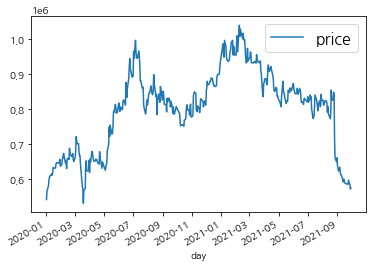

In [329]:
ncsoft_df.plot()
plt.show()

위 그래프를 보시면 최근 주가가 하락을 하고 있는것을 보이고 있다.  최고점 2021년 2월 8일 1,038,000원 최고점 주식이 현제 2021년 9월 29일 574,000원 으로 하락하고 있는것을 보고있다. 우리나라 대표하는 게임회사인데 다시 유저들을 마음을 헤아려 복귀했으면 한다.

# Step 2 예측: 파이썬 라이브러리를 활용해 시세 예측
첫 번째로 사용할 시계열 예측 분석 방법은 ARIMA 분석 방법입니다. ARIMA는 전통적인 시계열 예측 방법으로 크게 두 가지 계념을 포함하고 있습니다. 첫 번째는 AR(Autoregression)모델로 자기 자신의 과거를 정보로 사용하는 개념이다. 이는'현재의 상태는 이전의 상태를 참고해서 계산된다'라는 아이디어로 전제로 합니다.<br>
두 번째 개념은 MA(Moving Average)모델로 '이번 항에서의 오차를 이용하여 현재 항의 상태를 추론하겠다'라는 방법입니다. 그리고 이 둘을 합친것을 ARMA 모델이라고 하면, 조금 더 나아간 ARIMA(Autoregressice Integrated Miving Average)모델은 ARMA 모델에 추세 변동의 경향성까지 반영한 방법입니다.<br>
파이썬에서는 statsmodel 모듈로 ARIMA 분석을 수행할 수 있습니다. 다음 코드는 ARIMA 분석의 실행 과정입니다. ARIMA 클래스에 ordef=(2,1,2)라고 입력되어진 파라미터는 'AR이 몇 번째 과거까지를 바라보는지에 대한 파라미너(2), 차분에 대한 파라미너(1), AM가 몇 번째 과거까지를 바라보는지에 대한 파라미너(2)'를 의미하는 것입니다.<br>
이제 아래의 실행 결과를 분석해봅시다. 실행 결과의 표를 살펴보면 상수항을 제외한 모든 계수의 p-value가 0.05 이하로 유의미한 것으로 나타납니다. 이것은 AR과 MA모두 2로 설정하는 것이 꽤나 의미 있는 분석 결과를 도출한다는 것입니다.

In [330]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR = 2, 차분 =1, MA=2) 파라미터로 ARIMA 모델을 학습한다.
model = ARIMA(ncsoft_df.price.values, order = (2,1,2))
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

/home/dmlrkd67/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  431
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4896.781
Method:                       css-mle   S.D. of innovations          20795.361
Date:                Sun, 03 Oct 2021   AIC                           9805.561
Time:                        22:46:17   BIC                           9829.958
Sample:                             1   HQIC                          9815.194
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         76.5138    817.295      0.094      0.925   -1525.354    1678.382
ar.L1.D.y      0.0036      2.350      0.002      0.999      -4.602       4.609
ar.L2.D.y      0.4973      1.652      0.301      0.7

/home/dmlrkd67/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


다음으로 ARIMA 모델의 학습 결과를 알아보겠습니다. 아래의 실행 결과 중 첫 번째 그래프는 학습한 모델에 학습 데이터셋을 넣었을 때의 시계열 예측 결과입니다. plot_predict()라는 함수로 이러한 시각화를 자동으로 수행할 수 있습니다.

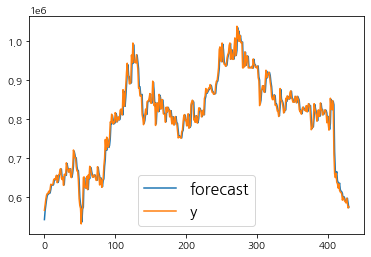

In [331]:
fig=model_fit.plot_predict() # 학습 데이터에 대한 예측 결과입니다.

<AxesSubplot:>

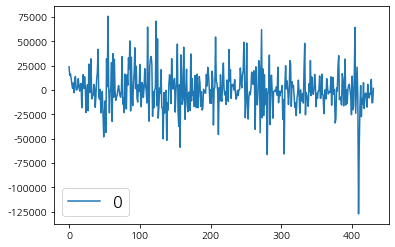

In [332]:
residuals=pd.DataFrame(model_fit.resid) # 잔차의 변동을 시각화합니다.
residuals.plot()

다음으로 ARIMA 모델을 평가해봅시다. 모델을 평가하기 위해서는 테스트 전용 데이터가 필요한데 이번 예제에서는 5일 동안의 미래를 테스트 데이터로 사용하겠습니다. 불규칙적 시계열 예측의 경우에는 먼 미래를 예측하는 것이 큰 의미가 없으므로'앞으로 N일 도안 어느정도로 상승/하락할것이다'정도의 대략적인 경향 예측만을 수행하는 것이 일반적이기 때문입니다.<br>
모델 평가의 과정은 다음과 같습니다.
- model_fit.forecast(steps=5)로 향후 5일의 가격을 예측하여 pred_y로 정의한다.
- ncsoft_df.iloc[427:]로 해주어 ncsoft_df의 마지막 5일을 test_y로 정의한다.
- 모델이 예측한 상한값,하한값을 pred_y_upper,pred_y_lower로 정의한다.
- 정의한 모든 값을 비교하여 5일 동안의 상승 경향 예측이 얼마나 맞았는지를 평가한다.

In [334]:
forecast_data = model_fit.forecast(steps=5)

# 마지막 5일의 예측 데이터 (2021-09-23 ~ 2021-09-29)
pred_arima_y = forecast_data[0].tolist()

# 실제 5일의 데이터 (2021-09-23 ~ 2021-09-29)
test_y = ncsoft_test_df.price.values

# 마지막 5일의 예측 데이터 최소값
pred_y_lower = []
# 마지막 5일의 예측 데이터 최대값
pred_y_upper = []

for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

그리고 다음 코드는 이를 그래프로 시각화한 것입니다. 파란색 그래프는 모델이 예상한 최고 가격, 즉 상한가의 그래프입니다. 그리고 빨간색은 모델이 예측한 하한가 그래프이고, 초록색은 실제 5일간의 가격 그래프, 노란색은 모델이 예측한 5일간의 가격 그래프를 나타낸 것입니다.

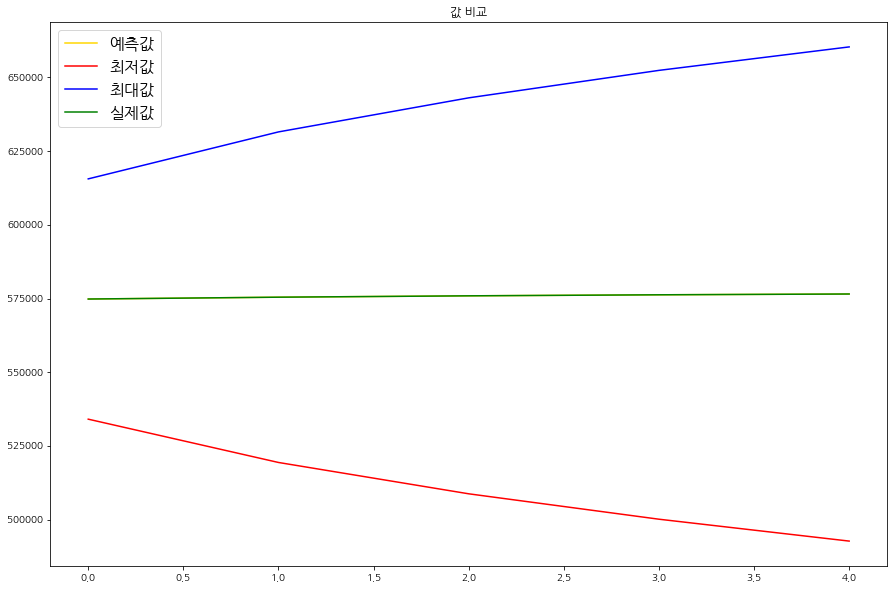

In [336]:
plt.figure(figsize=(15, 10))

plt.plot(pred_arima_y, color='gold') # 모델이 예측한 가격 그래프
plt.plot(pred_y_lower, color='red') # 모델이 예측한 최저 가격 그래프입니다.
plt.plot(pred_y_upper, color='blue') #  모델이 예측한 최고 가격 그래프입니다.
plt.plot(pred_y, color='green') # 실제 가격 그래프입니다.

plt.legend(['예측값', '최저값','최대값','실제값'])
plt.title("값 비교")
plt.show()

이번에는 ARIMA보다 조금 더 정확한 트렌드 예측 분석을 제공하는 라이브러리 'Facebook Prophet'을 사용해봅시다. Prophet은 Additive 모델링 방법에 기반한 시계열 예측 모델로서 시계열 데이터의 트렌드성(연간/월간/일간)을 예측하는 것에 초점이 맞추어져 있습니다.

### 여기서잠깐: Additive 모델
Additive 모델은 선형 회귀 분석의 단점을 극복하기 위해 개량된 분석 방법의 하나입니다. 시계열 분석 역시 회귀 분석의 한 갈래이기 떄문에 회귀 분석의 단점을 가지고 있습니다. 하지만 회귀 분석의 단점을 극복하기 위해 이 모델은 각 피처마다 비선형적 적합을 가능하게 하는 일련의 방법을 적용합니다. 이는 다소 어려운 내용이므로 자세한 내용을 알고 싶다면 https://peerj.com/preprints/3190/ 을 참고하길 바랍니다.

fbprophet 라이브러리를 사용하기 위해서는 데이터 프레임의 피처를 'ds'와 'y'로 변경해야 합니다. 그리고 Prophet이라는 클래스를 선언한 뒤, fit() 함수로 모델을 학습시킵니다. 모델 생성에 포함되는 파라미터의 의미는 다음과 같습니다.
- seasonality_mode : 연간, 월간, 주간, 일간 등의 트렌드성을 반영하는 것을 의미하는 파라미터입니다.
- changepoint_prior_scale : 트렌드가 변경되는 문맥을 반영하는 파라미터입니다. 수치가 높을수록 모델은 과적합에 가까워집니다.

아래 코드는 Facebook Prophet을 활용하여 시계열 모델을 학습하는 코드입니다.

In [337]:
from fbprophet import Prophet

ncsoft_df = ncsoft_df.reset_index()

ncsoft_df.columns = ['ds','y']

ncsoft_train_df = ncsoft_df[:427]
ncsoft_test_df = ncsoft_df[427:]

prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)

prophet.fit(ncsoft_train_df)

그리고 다음 코드 중 make_future_dataframe(periods=5, freq='d'), prophet.predict(future_data)를 실행하면 학습 데이터셋 기반의 5일 단위 예측 데이터를 얻을 수 있습니다. 아래의 실행 결과는 데이터에 존재하지 않는 5일 단위의 미래를 예측한 것입니다.

In [338]:
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)
forecast_data[['ds','yhat','yhat_lower','yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
427,2021-09-18,479195.435617,449879.049952,507665.315840
428,2021-09-19,474824.813914,445530.913970,504484.066014
429,2021-09-20,556768.917650,528873.919950,586425.937189
430,2021-09-21,552667.307359,523509.221475,583470.024377
431,2021-09-22,549822.629410,521986.363190,579938.066415


다음은 fbprophet 모델의 학습 결과를 시각화한 결과입니다. 그래프의 검은 점은 실제 가격을 나타낸 것이고, 파란 선은 예측 가격을 나타낸 것입니다. 이 모델 역시 ARIMA 모델과 마찬가지로 학습 데이터셋에 대해서는 거의 정확한 예측을 하고 있습니다. 하지만 시계열 데이터 분석에서 학습 데이터를 잘 예측하는 것은 큰 의미가 없다고 할 수 있습니다.

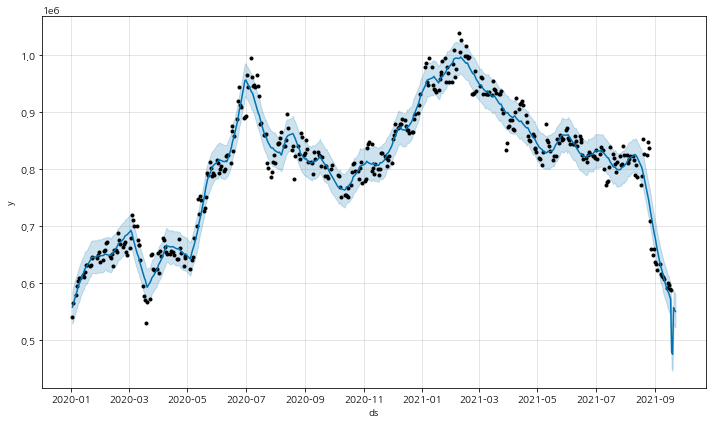

In [339]:
pig1 = prophet.plot(forecast_data)

그리고 다음의 그래프는 fbprophet에서 제공하는 트렌드 정보 시각화 그래프입니다. 앞서 seasonality_mode 파라미터를 설정해놓은 경우에만 이 시각화가 가능합니다. 우리는 이를 통해 시계열 데이터가 어떤 흐름을 가지고 변화하는지를 살펴볼 수 있습니다. 전체적인 데이터의 트렌드는 아래의 첫 번째 그래프로 살펴볼 수 있고, 이어지는 그래프에서 year, weekly, daily 순의 트렌드를 확인할 수 있습니다.

/home/dmlrkd67/anaconda3/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/home/dmlrkd67/anaconda3/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/home/dmlrkd67/anaconda3/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


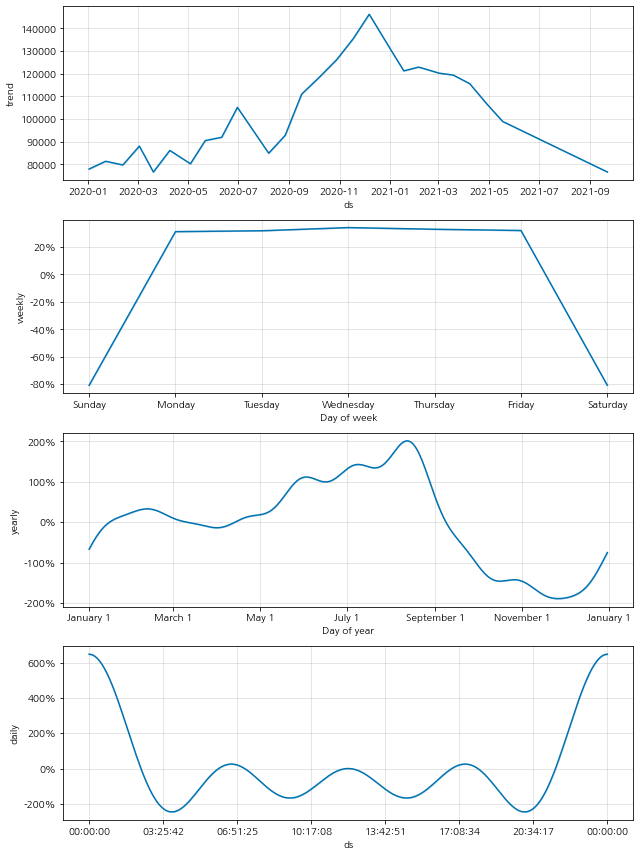

In [340]:
fig2 = prophet.plot_components(forecast_data)

ARIMA 모델을 평가한 것과 동일한 방법으로 테스트 데이터셋을 평가해봅시다. 

Text(0.5, 1.0, '값 비교')

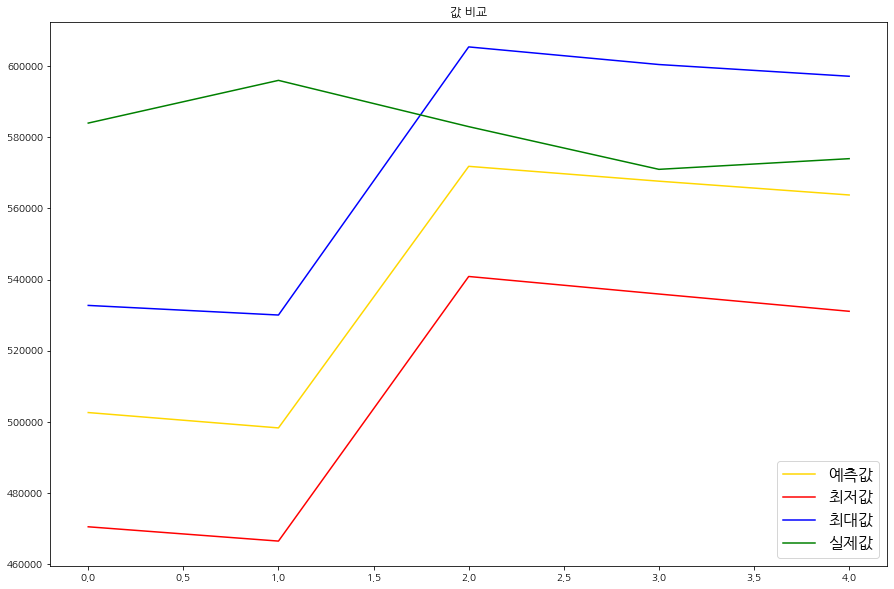

In [351]:
plt.figure(figsize=(15, 10))
# 실제 5일의 가격 데이터입니다. (2021 )
pred_fbprophet_y = forecast_data.yhat.values[-5:]
test_y = ncsoft_test_df.y.values
# 마지막 5일 예측 데이터의 최소값입니다.
pred_y_lower = forecast_data.yhat_lower.values[-5:]
# 마지막 5일의 예측 데이터의 최대값 입니다.
pred_y_upper = forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최저 가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최고 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.
plt.legend(['예측값', '최저값','최대값','실제값'])
plt.title("값 비교")

# Step 3 활용: 더나은 결과를 위한 방법
이번 분석 단계에서는 모델의 성능을 조금 더 향상시킬 수 있는 방법들에 대해 알아보겠습니다.<br>
첫 번째로 고려해볼 방법은 상한값 혹은 하한값을 지정해 주는 것입니다. 바닥과 천장이 없는 주가 데이터의 경우에는 의미가 없을 수 있지만 일반적인 시계열 데이터에서는 상한값 혹은 하한값을 설정해 주는 것이 모델의 성능을 높여줄 수 있는 방법 중 하나입니다.<br>
Prophet 모델에서는 future_data['cap'] = 1000000을 통해 데이터셋에 상한선을 설정할 수 있습니다. 다음 코드와 실행 결과는 상한선을 적용한 학습 결과를 시각화한 것입니다. 겉으로 보기에는 월래의 결과와 별 차이가 없어 보입니다.

In [352]:
# 상한가 설정
ncsoft_train_df['cap'] = 1000000

# 상한가 적용을 위한 파라미터를 다음과 같이 설정
prophet = Prophet(seasonality_mode = 'multiplicative',
                 growth = 'logistic',
                 yearly_seasonality = True,
                 weekly_seasonality = True, 
                 daily_seasonality = True,
                 changepoint_prior_scale = 0.5)

prophet.fit(ncsoft_train_df)

# 5일 예측 
future_data = prophet.make_future_dataframe(periods = 5, freq = 'd')

# 상한가 설정
future_data['cap'] = 1000000
forecast_data = prophet.predict(future_data)

<ipython-input-352-6febcda6157d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ncsoft_train_df['cap'] = 1000000


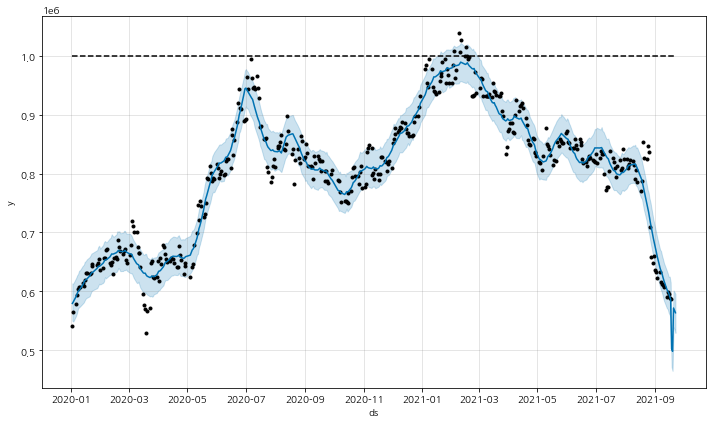

In [353]:
fig = prophet.plot(forecast_data)

이번에는 아래의 코드로 예측값과 실제값을 비교해봅시다.

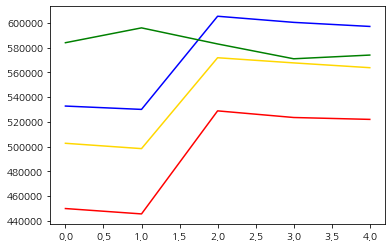

In [344]:
#마지막 5일의 예측 데이터입니다. 
pred_y = forecast_data.yhat.values[-5:]
#실제 5일의 가격 데이터입니다. 
test_y = ncsoft_test_df.y.values
# 마지막 5일 예측 데이터의 최소값입니다.
pred_y_lower - forecast_data.yhat_lower.values[-5:]
# 마지막 5일의 예측 데이터의 최대값입니다.
pred_y_upper = forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최저 가격 그래프입니다.
plt.plot(pred_y_upper, color='blue') # 모델이 예상한 최고 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [345]:
pred_fbprophet_y_1 = forecast_data.yhat.values[-5:]

# Step 4: Model 평가
지금까지 ARIMA, FBprophet 가지고 엔씨소프트 주가를 예측 해보았다. 이제는 각각의 모델이 엔씨소프트 주가를 어떻게 예측을 하고 있는지 비교를 해보자.

In [346]:
df = pd.DataFrame({'ARIMA 예측값':pred_y,
                   'FBprophet 예측값': pred_y,
                   '실제값':test_y})

In [347]:
df

,ARIMA 예측값,FBprophet 예측값,실제값
0,502656.322359,502656.322359,584000.0
1,498341.596690,498341.596690,596000.0
2,571845.523592,571845.523592,583000.0
3,567671.682920,567671.682920,571000.0
4,563795.943973,563795.943973,574000.0


Text(0.5, 1.0, '값 비교')

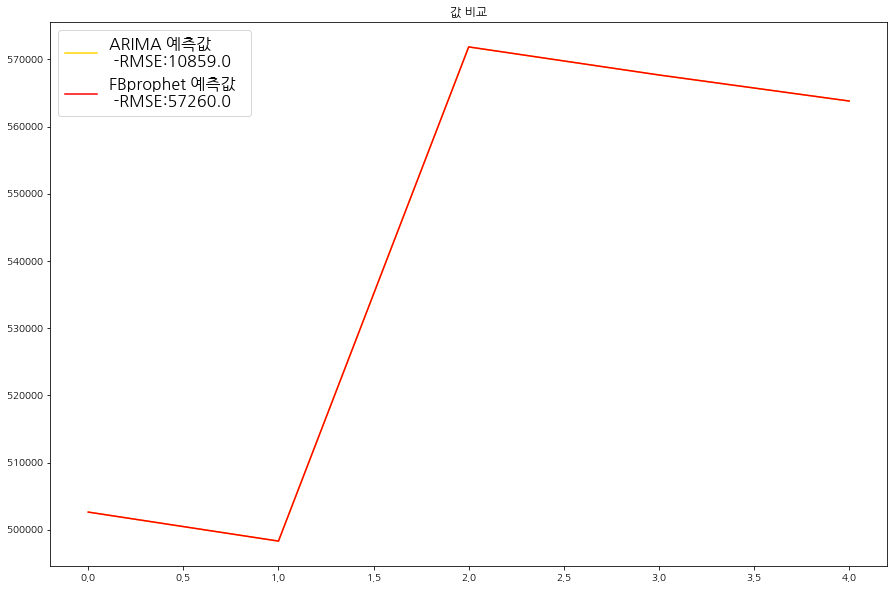

In [350]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

plt.figure(figsize=(15, 10))

# arima 모델의  rmse
rmse_arima = sqrt(mean_squared_error(pred_arima_y, test_y))

# fbprophet 모델의  rmse
rmse_fbprophet = sqrt(mean_squared_error(pred_y, test_y))

# 모델이 예측한 가격 그래프
plt.plot(df[['ARIMA 예측값']], color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(df[['FBprophet 예측값']], color = 'red')

# 실제 가격 그래프
# plt.plot(test_y, color = 'green')

plt.rc('legend', fontsize=16)
plt.legend(['ARIMA 예측값 \n -RMSE:' + str(round(rmse_arima,0)), 
            'FBprophet 예측값  \n -RMSE:' + str(round(rmse_fbprophet,0))])
            
plt.title("값 비교")